In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import time
from geopy.geocoders import ArcGIS

<h1> Importing Data

In [2]:
url2 = 'https://raw.githubusercontent.com/JeroenGuillierme/Project-MDA/main/Data/'

aed_data = pd.read_csv(
    f'{url2}aed_df_with_distances.csv')

# Load Belgium shapefile
belgium_boundary = gpd.read_file(f'{url2}Belgi%C3%AB.json')
# Load Belgium with regions shapefile
belgium_with_provinces_boundary = gpd.read_file(f'{url2}BELGIUM_-_Provinces.geojson')

pd.set_option('display.max_columns', None)

There are currently 13916 AEDs in Belgium


<h1> Functions

In [20]:
# Function to calculate cell size in decimal degrees based on desired grid area and latitude
def calculate_cell_size(grid_area_km2, latitude_degrees):
    '''
    This function calculates the cell size in degrees based on a given grid size in km² and the latitude coordinate.
    :param grid_area_km2: Wanted grid are in km².
    :param latitude_degrees: The latitude coordinate at which the grid size in degrees need to be calculated.
    :return: The degrees of the cell size used to split Belgium up in different grids of given area in km².
    '''
    # Convert latitude to radians for trigonometric functions
    latitude_rad = np.radians(latitude_degrees)

    # Conversion factor from meters to decimal degrees for latitude
    meters_to_degrees = 1 / (111.32 * 1000 * np.cos(latitude_rad))

    # Calculate width of the square grid cell in meters
    width_meters = np.sqrt(grid_area_km2 * 1000000)

    # Calculate cell size in decimal degrees
    cell_size_degrees = width_meters * meters_to_degrees

    return cell_size_degrees

<h1> Data Preparation

Create two different datasets which only contain the intervention and AED locations respectively.

In [24]:
interventions_data = aed_data[aed_data['Intervention'] == 1]
aed_locations = aed_data[aed_data['AED'] == 1]
print(f'There are currently {len(aed_locations)} AEDs in Belgium')


There are currently 13916 AEDs in Belgium


In [4]:
# Check for missing values
print('Missing values per variable: \n', interventions_data.isnull().sum())
print('Length dataset: ', len(interventions_data))

Missing values per variable: 
 Latitude                    0
Longitude                   0
Intervention                0
Eventlevel                  0
T3-T0                    1965
EventType                   0
AED                         0
Ambulance                   0
Mug                         0
distance_to_aed             0
distance_to_ambulance       0
distance_to_mug             0
dtype: int64
Length dataset:  11261


**Replacing Missing Response Times From Grid Locations with (KNN) Imputed values Based On Location adn Distances**

Assign response time to added locations in the dataset
Using KNN Imputer

* Feature Selection: Selected Latitude, Longitude, and T3-T0_min for imputation. 
* Scaling: Scaled Latitude and Longitude using StandardScaler. 
            This ensures that these features contribute equally to the distance calculation in the KNN Imputer.
* KNN Imputation: KNN Imputer applied to the scaled data to fill in the missing values.
* Inverse Transform: After imputation, the scaled features were inverse transformed back to their original scale 
                    and reassigned the imputed response times (T3-T0_min) back to the original dataframe.rame.

In [5]:
# Select features for imputation
features_for_imputation = interventions_data[['Latitude', 'Longitude', 'distance_to_ambulance',
                                              'distance_to_mug', 'T3-T0']]

features_for_imputation = pd.DataFrame(features_for_imputation,
                                       columns=['Latitude', 'Longitude', 'distance_to_ambulance',
                                                'distance_to_mug', 'T3-T0'])
features_for_imputation.head(5)

,Latitude,Longitude,distance_to_ambulance,distance_to_mug,T3-T0
0,51.20685,5.13662,3.523140,8.380098,18.884917
1,51.24848,4.43869,1.259929,1.259929,4.238700
2,51.24848,4.43869,1.259929,1.259929,12.612550
3,51.28273,4.42134,3.262920,3.434839,13.427900
4,51.28273,4.42134,3.262920,3.434839,36.619500


In [6]:
# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)
# Perform KNN Imputation
imputed_values = knn_imputer.fit_transform(features_for_imputation)
# Create a dataframe with the imputed values
imputed_data = pd.DataFrame(imputed_values, columns=['Latitude', 'Longitude', 'distance_to_ambulance',
                                                     'distance_to_mug', 'T3-T0'])
imputed_data.head()

,Latitude,Longitude,distance_to_ambulance,distance_to_mug,T3-T0
0,51.20685,5.13662,3.523140,8.380098,18.884917
1,51.24848,4.43869,1.259929,1.259929,4.238700
2,51.24848,4.43869,1.259929,1.259929,12.612550
3,51.28273,4.42134,3.262920,3.434839,13.427900
4,51.28273,4.42134,3.262920,3.434839,36.619500


**Assign the imputed values back to the original dataframe**

In [13]:
interventions_data.loc[:, 'T3-T0'] = imputed_data['T3-T0']

**Remove duplicated values from the dataset**

In [14]:
print('------------- Before removing duplicates -------------')
# Verify the imputation
len1=len(interventions_data)
print('Total length of interventions dataset: ', len1)

interventions_data_without_outliers = interventions_data.drop_duplicates()

print('------------- After removing duplicates -------------')
# Verify the imputation
len2=len(interventions_data_without_outliers)
print('Total length of interventions dataset: ', len2)
print('In total: ', len1-len2, ' duplicates removed.')

interventions_data[interventions_data.duplicated(keep=False)==True].head(6) # visual check if the rows are in fact exactly the same

------------- Before removing duplicates -------------
Total length of interventions dataset:  11261
------------- After removing duplicates -------------
Total length of interventions dataset:  9329
In total:  1932  duplicates removed.


,Latitude,Longitude,Intervention,Eventlevel,T3-T0,EventType,AED,Ambulance,Mug,distance_to_aed,distance_to_ambulance,distance_to_mug
2103,50.66422,4.34642,1,1.0,9.284300,P003 - Cardiac arrest,0,0,0,0.372095,2.657701,2.657701
2104,50.66422,4.34642,1,1.0,9.284300,P003 - Cardiac arrest,0,0,0,0.372095,2.657701,2.657701
2600,50.32854,4.45018,1,1.0,18.026867,P003 - Cardiac arrest,0,0,0,0.266389,5.134940,9.219828
2601,50.32854,4.45018,1,1.0,18.026867,P003 - Cardiac arrest,0,0,0,0.266389,5.134940,9.219828
5140,49.78111,5.06125,1,1.0,25.107117,P003 - Cardiac arrest,0,0,0,1.562132,3.664443,82.215528
5141,49.78111,5.06125,1,1.0,25.107117,P003 - Cardiac arrest,0,0,0,1.562132,3.664443,82.215528


# Heatmap of Incident Desnity

Create kernel density estimate (KDE) plot.

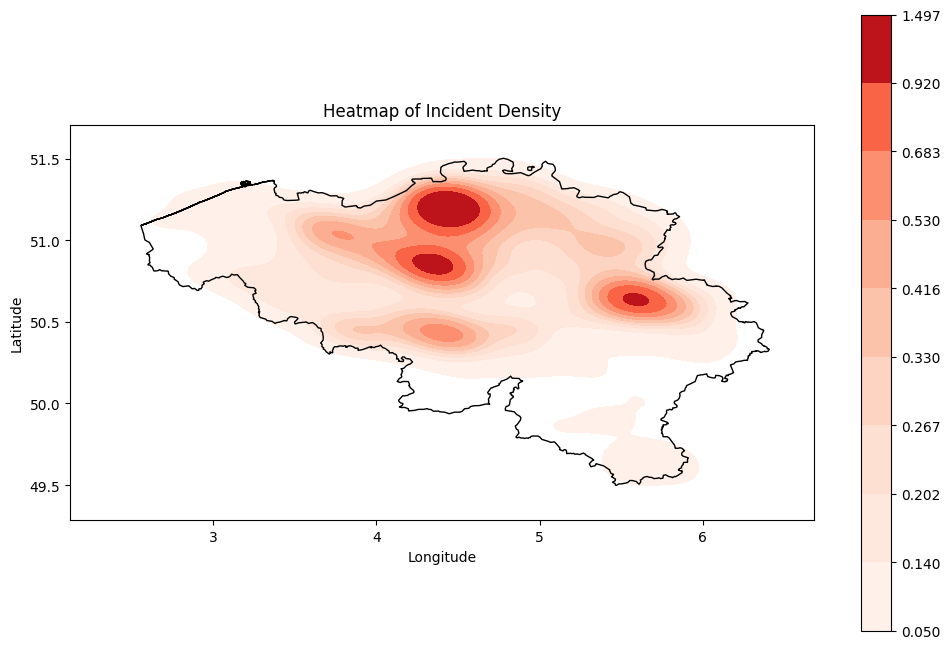

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))

kde = sns.kdeplot(data=interventions_data_without_outliers, x='Longitude', y='Latitude', cmap='Reds',
                  fill=True, ax=ax, cbar=True)

belgium_boundary.plot(ax=ax, facecolor='none', edgecolor='black')
ax.set_title('Heatmap of Incident Density')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

**Create a GeaDataframe from the interventions data**

In [21]:
# Create a GeoDataFrame from interventions data
gdf_interventions = gpd.GeoDataFrame(
    interventions_data_without_outliers,
    geometry=gpd.points_from_xy(interventions_data_without_outliers.Longitude, interventions_data_without_outliers.Latitude)
)
# Filter out invalid geometries
gdf_interventions = gdf_interventions[gdf_interventions['geometry'].is_valid]

**Adding Incident Density to Dataset**   

The mean latitude is: 50.830706204739734
The cell size in degrees is: 0.024634046137982712


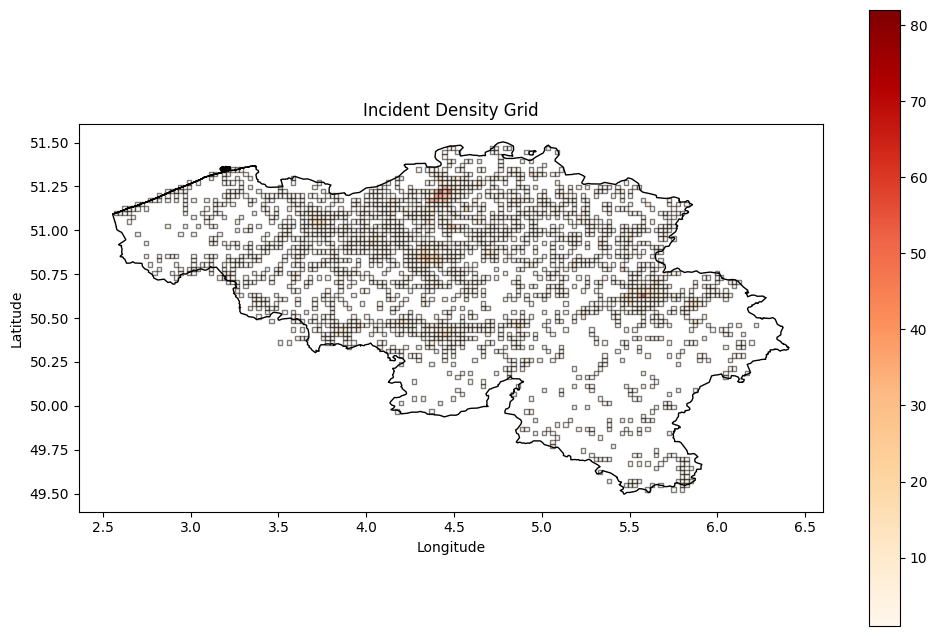

In [22]:
# Example parameters
grid_area_km2 = 3  # Desired grid area in km²

# Calculate mean latitude from gdf_interventions
mean_latitude = gdf_interventions.geometry.centroid.y.mean()
print(f'The mean latitude is: {mean_latitude}')

# Calculate cell size in decimal degrees
cell_size_degrees = calculate_cell_size(grid_area_km2, mean_latitude)
print(f'The cell size in degrees is: {cell_size_degrees}')

# Create a grid over the study area
xmin, ymin, xmax, ymax = gdf_interventions.total_bounds
cell_size = 0.03  # Adjust the cell size as needed
grid_cells = []
for x0 in np.arange(xmin, xmax + cell_size_degrees, cell_size_degrees):
    for y0 in np.arange(ymin, ymax + cell_size_degrees, cell_size_degrees):
        x1 = x0 - cell_size_degrees
        y1 = y0 + cell_size_degrees
        grid_cells.append(Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)]))

grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'])

# Filter out invalid geometries
grid = grid[grid['geometry'].is_valid]

# Spatial join the grid with the intervention points
joined_interventions = gpd.sjoin(gdf_interventions, grid, how='left')

# Count incidents in each grid cell
incident_counts = joined_interventions.groupby('index_right').size()

# Map incidents counts to the grid
grid['incident_count'] = np.nan
grid.loc[incident_counts.index, 'incident_count'] = incident_counts.values
# print(grid['incident_count'].sort_values(ascending=True).value_counts())

# Perform a spatial join to add the incident_count to the interventions data
gdf_interventions_with_incident_count = gpd.sjoin(gdf_interventions, grid[['geometry', 'incident_count']], how='left')

# Plot the incident density
fig, ax = plt.subplots(figsize=(12, 8))
grid.plot(column='incident_count', ax=ax, cmap='OrRd', edgecolor='k', alpha=0.5, legend=True)
belgium_boundary.plot(ax=ax, facecolor='none', edgecolor='black')
ax.set_title('Incident Density Grid')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Drop the index right column
gdf_interventions_with_incident_count = gdf_interventions_with_incident_count.drop(columns='index_right')

# Heatmap of AED Density

Create kernel density estimate (KDE) plot.

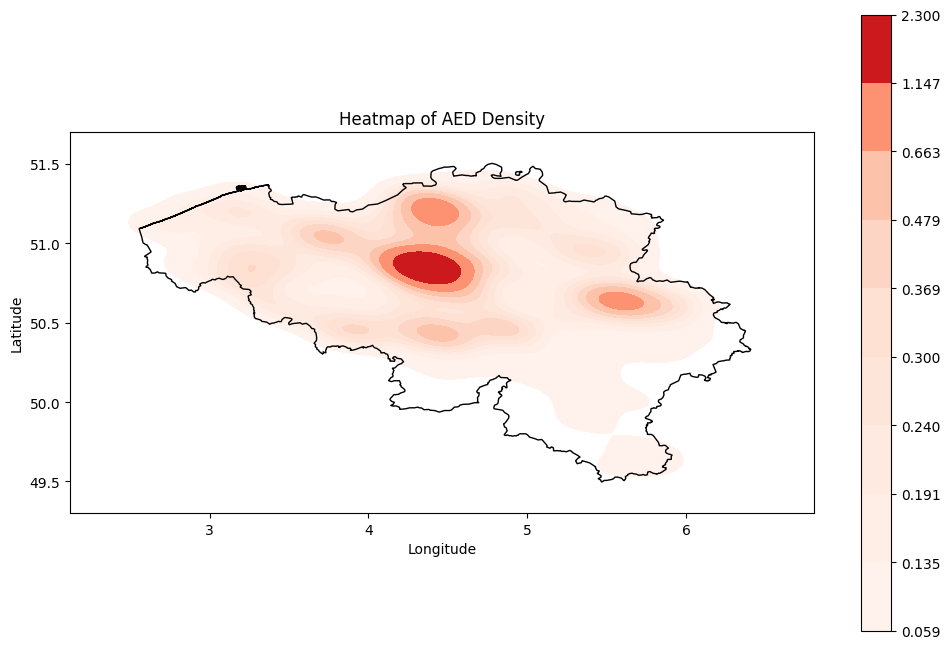

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))

kde = sns.kdeplot(data=aed_locations, x='Longitude', y='Latitude', cmap='Reds',
                  fill=True, ax=ax, cbar=True)

belgium_boundary.plot(ax=ax, facecolor='none', edgecolor='black')
ax.set_title('Heatmap of AED Density')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

**Creating GeoDataframe from AED locations dataset**

In [23]:
# Convert to GeoDataFrame
gdf_aed_locations = gpd.GeoDataFrame(
    aed_locations,
    geometry=gpd.points_from_xy(aed_locations.Longitude, aed_locations.Latitude)
)

**Adding AED Density to Dataset**

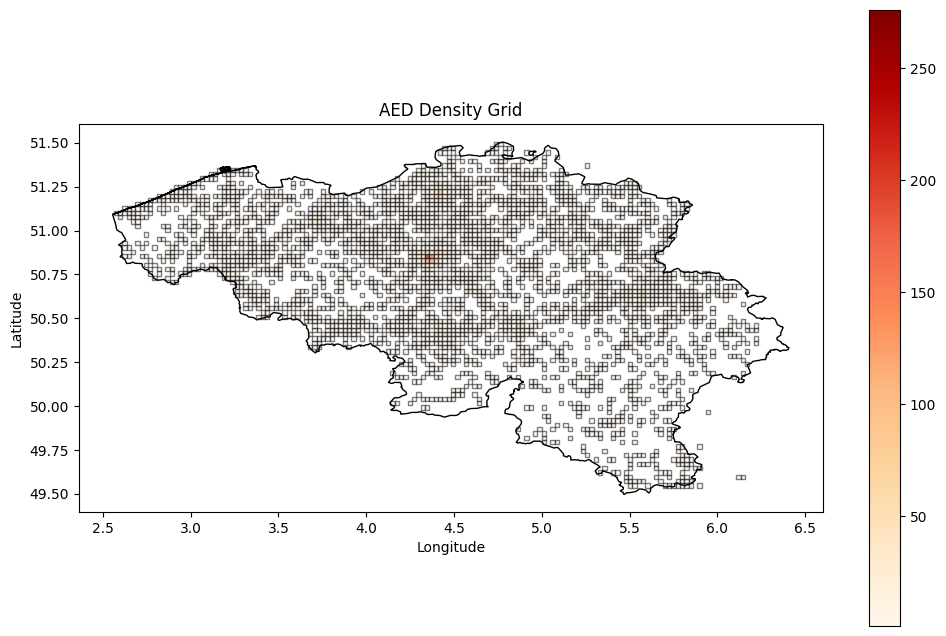

In [42]:
# Spatial join the grid with the aed points
joined_aed = gpd.sjoin(gdf_aed_locations, grid, how='left')

# Count incidents in each grid cell
aed_counts = joined_aed.groupby('index_right').size()

# Map incidents counts to the grid
grid['aed_count'] = np.nan
grid.loc[aed_counts.index, 'aed_count'] = aed_counts.values


# Perform a spatial join to add the incident_count to the interventions data
gdf_interventions_with_both_count = gpd.sjoin(gdf_interventions_with_incident_count, grid[['geometry', 'aed_count']],
                                              how='left')

# Plot the AED density
fig, ax = plt.subplots(figsize=(12, 8))
grid.plot(column='aed_count', ax=ax, cmap='OrRd', edgecolor='k', alpha=0.5, legend=True)
belgium_boundary.plot(ax=ax, facecolor='none', edgecolor='black')
ax.set_title('AED Density Grid')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [61]:
gdf_interventions_with_both_count.drop(columns='index_right').head(5)

,Latitude,Longitude,Intervention,Eventlevel,T3-T0,EventType,AED,Ambulance,Mug,distance_to_aed,distance_to_ambulance,distance_to_mug,geometry,incident_count,aed_count
0,51.20685,5.13662,1,1.0,18.884917,P003 - Cardiac arrest,0,0,0,1.239539,3.523140,8.380098,POINT (5.13662 51.20685),10.0,3.0
1,51.24848,4.43869,1,1.0,4.238700,P003 - Cardiac arrest,0,0,0,0.335321,1.259929,1.259929,POINT (4.43869 51.24848),48.0,22.0
2,51.24848,4.43869,1,1.0,12.612550,P003 - Cardiac arrest,0,0,0,0.335321,1.259929,1.259929,POINT (4.43869 51.24848),48.0,22.0
3,51.28273,4.42134,1,1.0,13.427900,P003 - Cardiac arrest,0,0,0,0.083377,3.262920,3.434839,POINT (4.42134 51.28273),19.0,32.0
4,51.28273,4.42134,1,1.0,36.619500,P003 - Cardiac arrest,0,0,0,0.083377,3.262920,3.434839,POINT (4.42134 51.28273),19.0,32.0


# Response Time Analysis

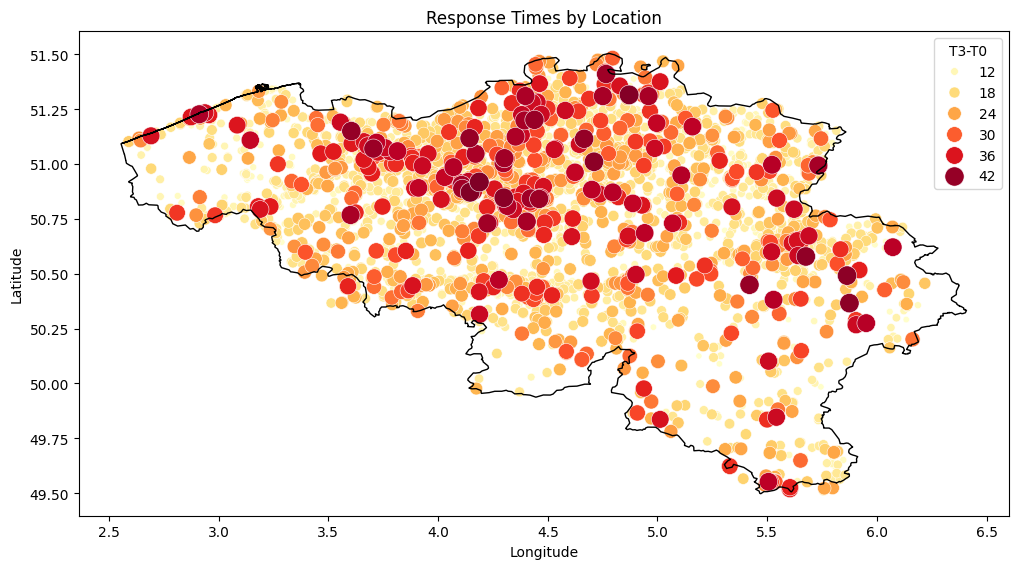

In [62]:
# Only check Response times longer then 10 minutes
# (According to literature waiting longer ten 10 minutes could be life-threatening)
ResponseTimeFilterd = gdf_interventions_with_both_count[gdf_interventions_with_both_count['T3-T0'] > 10]
ResponseTimeFilterd_sorted = ResponseTimeFilterd.sort_values(by='T3-T0', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))
scatter = sns.scatterplot(
    data=ResponseTimeFilterd_sorted,
    x='Longitude', y='Latitude',
    hue='T3-T0', palette='YlOrRd',
    size='T3-T0',
    sizes=(20, 200), legend='brief', ax=ax)
belgium_boundary.plot(ax=ax, facecolor='none', edgecolor='black')
ax.set_title('Response Times by Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Identifying High-Risk Areas with Low AED Coverage

These thresholds are chosen a little arbitrary.
We defined a high risk area as an area where there have been more than 5 cardiac arrests per 3km² 
with a response time larger than 10 minutes in public places.

Literature says (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7892213/): 

'We found that a short Emergency Medical Service (EMS) response time was associated with a high rate of survival 
to hospital discharge after Out-of-Hospital Cardiac Arrest (OHCA). 
The optimal response time threshold for survival to hospital discharge was 6.2min. 
In the case of OHCA in public areas or with bystander CPR, the threshold was prolonged to 7.2min and 6.3min, 
respectively; and in the absence of a witness, the threshold was shortened to 4.2min.'

About the incident density it says:

'Incident density, or the frequency of events in a specific area, can impact ambulance response times and survival 
outcomes for out-of-hospital cardiac arrest (OHCA) patients.
High incident density areas may lead to longer response times due to increased demand on emergency medical services(EMS)
resources.'

In [65]:
# Define high-risk based on response time and incident frequency
response_time_threshold = 10  # minutes
incident_density_threshold = 5  # more than five previous interventions on that location area
aed_density_threshold = 5  # less than 5 aeds in the 3 km³ grid for that location
# Identify high-risk areas
high_risk_areas = gdf_interventions_with_both_count[
    (gdf_interventions_with_both_count['T3-T0'] > response_time_threshold) &
    (gdf_interventions_with_both_count['incident_count'] > incident_density_threshold) &
    (gdf_interventions_with_both_count['aed_count'] < aed_density_threshold)
    ]

print(
    'Number of high risk areas in Belgium according to chosen thresholds: ',
    len(high_risk_areas[['Latitude', 'Longitude']].drop_duplicates()))


Number of high risk areas in Belgium according to chosen thresholds:  468


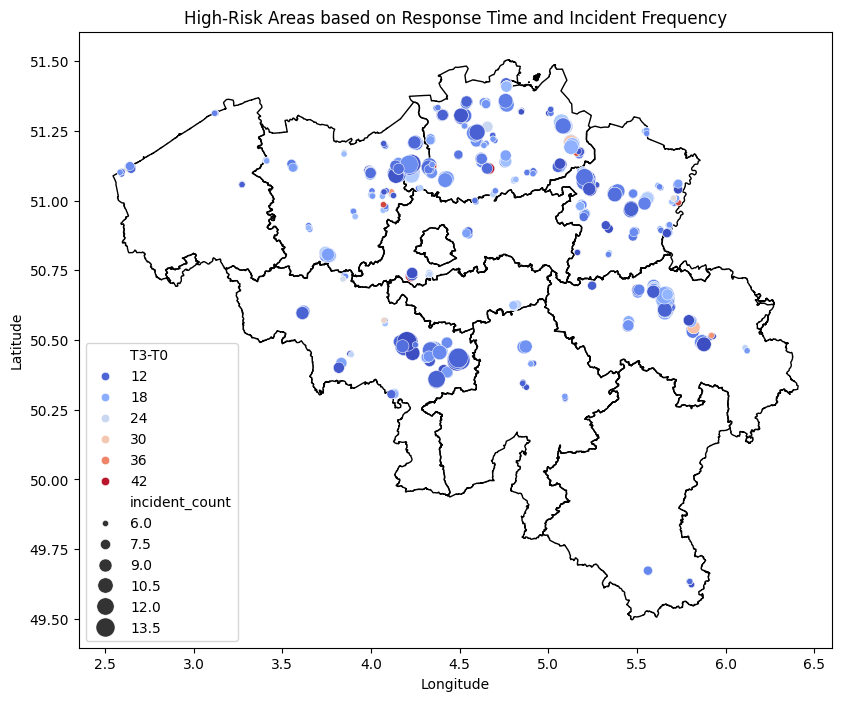

In [66]:
# Visualise high-risk areas
fig, ax = plt.subplots(figsize=(12, 8))
belgium_with_provinces_boundary.plot(ax=ax, facecolor='none', edgecolor='black')
scatter = sns.scatterplot(data=high_risk_areas,
                          x='Longitude', y='Latitude',
                          size='incident_count', hue='T3-T0', palette='coolwarm',
                          sizes=(20, 200), legend='auto', ax=ax)
ax.set_title('High-Risk Areas based on Response Time and Incident Frequency')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


You can see a lot of cardiac arrests in Antwerp, Brussels and Luik (and also on the lin Bergen, Charleroi, Namen)

# Clustering High-Risk Areas Using DBSCAN as spatial clustering algorithm

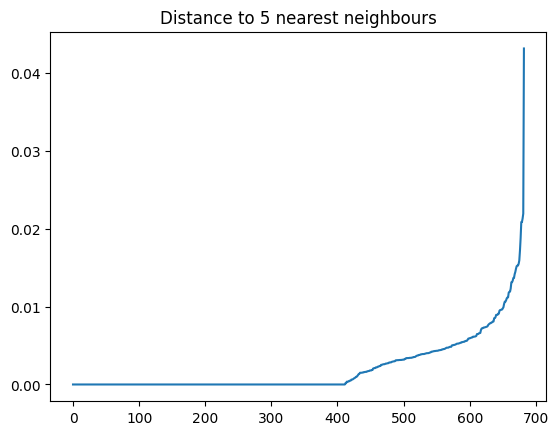

In [69]:
# Identify high-risk areas to identify hotspots or highly concentrated high risk areas
high_risk_areas = high_risk_areas.dropna(subset=['Latitude', 'Longitude'])

# Calculate the average distance between each point in the data set and its 20 nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(high_risk_areas[['Latitude', 'Longitude']])
distances, indices = neighbors_fit.kneighbors(high_risk_areas[['Latitude', 'Longitude']])
# Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.title('Distance to 5 nearest neighbours')
plt.plot(distances)

# Choose eps based on the k-distance graph
eps = cell_size_degrees  # See earlier for determining grid size: eps = 0.02463... this is approximately 3km
# Choose min_samples based on the data density
# A point is considered a core point if at least 5 points are within a distance of 3km
min_samples = 5

# Initialize DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Perform clustering
high_risk_areas['cluster'] = dbscan.fit_predict(high_risk_areas[['Latitude', 'Longitude']])

# Drop noise points (cluster == -1)
# Filter out noise points (cluster == -1)
high_risk_areas_filtered = high_risk_areas[high_risk_areas['cluster'] != -1]

**Determine new AED locations (cluster centers)**

In [72]:
cluster_centers = high_risk_areas_filtered.groupby('cluster').mean()[['Latitude', 'Longitude']]
cluster_sizes = high_risk_areas_filtered['cluster'].value_counts()
labels = dbscan.labels_

print('New AED Locations: \n', cluster_centers)


,Latitude,Longitude
cluster,,
0,51.203681,5.130881
1,51.269669,5.084268
2,51.101027,4.902522
3,51.147635,4.621707
4,51.308757,4.403577
...,...,...
72,51.199862,4.075461
73,51.100603,3.996522
74,51.143332,3.409994


In [ ]:
cluster_centers = high_risk_areas_filtered.groupby('cluster').mean()[['Latitude', 'Longitude']]
cluster_sizes = high_risk_areas_filtered['cluster'].value_counts()
labels = dbscan.labels_

print('New AED Locations: \n', cluster_centers)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# Plot clusters
fig, ax = plt.subplots(figsize=(12, 8))
custom_palette = sns.color_palette("Paired", len(cluster_sizes) + 1)
# Plot the high-risk areas and color by cluster
scatter = sns.scatterplot(
    data=high_risk_areas,
    x='Longitude', y='Latitude',
    hue='cluster', palette=custom_palette,
    size='incident_count',
    sizes=(20, 200), legend=False, ax=ax)
# Overlay the Belgium boundary
belgium_boundary.plot(ax=ax, facecolor='none', edgecolor='black')

# Overlay the proposed AED locations
new_aed_gdf = gpd.GeoDataFrame(cluster_centers,
                               geometry=gpd.points_from_xy(cluster_centers['Longitude'], cluster_centers['Latitude']))
new_aed_gdf.plot(ax=ax, marker='x', color='blue', markersize=100, label='Proposed AED Locations')

ax.set_title('High-Risk Areas Clusters and Proposed AED Locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# New plot for cluster sizes
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare cluster centers with sizes
cluster_centers['size'] = cluster_sizes

# Plot only cluster centers with sizes and colors depending on cluster size to determine most 'problematic' clusters
belgium_with_provinces_boundary.plot(ax=ax, facecolor='none', edgecolor='black')
scatter = sns.scatterplot(data=cluster_centers,
                          x='Longitude', y='Latitude', size='size', sizes=(20, 200),
                          hue='size', palette='coolwarm', legend='brief')
ax.set_title('Cluster Centers with Sizes Proportional to Cluster Sizes')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

# Evaluation metrics

sc = silhouette_score(high_risk_areas[['Latitude', 'Longitude']], labels)
print("Silhouette Coefficient:%0.2f" % sc)
# For incident_density_threshold = 10: sc = -0.13 and 11 clusters
# For incident_density_threshold = 5: sc = 0.69  and 82 clusters

# Save cluster centers to new csv file
#new_aed_gdf[['Latitude', 'Longitude']].to_csv(
#    'C:/Users/Admin/Documents/GitHub/Project-AED-optimalization/DATA/new_aed_locations.csv', index=True)